## Head

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from typing import List, Tuple

In [ ]:
import pylift
import causalml.metrics as cmetrics

from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
#import pylift_utils

## Utils

In [ ]:
def uplift_at_k(
    predictions: pd.DataFrame,
    data: pd.DataFrame,
    col_target: str,
    col_id: str,
    col_treatment: str,
    ratio_top: float = 0.3
) -> float:
    assert len(predictions) == len(data)
    n_top = int(len(data) * ratio_top)
    top = (
        predictions
        .sort_values(by=['score'], ascending=False)
        .merge(data[[col_id, col_treatment, col_target]], on=[col_id], how='inner')
        .iloc[: n_top]
    )
    tmp = top.groupby(by=[col_treatment])[col_target].mean()
    return tmp.loc[1] - tmp.loc[0]

## Load'n'cook

### load

Загружаем весь датасет с соревнования от MineThatData. (не только ту часть, которая была выдана в ДЗ).

In [ ]:
data = pd.read_csv('data/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

### transform

In [ ]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result

In [ ]:
def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
    data['history_segment__label'] = data['history_segment'].apply(lambda s: s[0])
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

In [ ]:
data = transform_(data)

In [ ]:
data_womens = data.query('segment in ("No E-Mail", "Womens E-Mail")')

In [ ]:
data_womens['treatment'] = (data_womens['segment'] == 'Womens E-Mail').astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### fit / validation split

In [ ]:
fit_index, val_index = train_test_split(data_womens.index, test_size=0.5, random_state=148)

In [ ]:
treated_fit_index = data_womens.loc[fit_index, ['treatment']].query('treatment == 1').index
treated_val_index = data_womens.loc[val_index, ['treatment']].query('treatment == 1').index

In [ ]:
control_fit_index = data_womens.loc[fit_index, ['treatment']].query('treatment == 0').index
control_val_index = data_womens.loc[val_index, ['treatment']].query('treatment == 0').index

### column sets

In [ ]:
data_womens.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend',
       'zip_code_num', 'channel_num', 'history_segment__label',
       'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web',
       'history_segment__label_1', 'history_segment__label_2',
       'history_segment__label_3', 'history_segment__label_4',
       'history_segment__label_5', 'history_segment__label_6',
       'history_segment__label_7', 'treatment'],
      dtype='object')

In [ ]:
column_set_n1 = [
    'recency',
    'history',
    'mens',
    'womens',
    'zip_code_num',
    'channel_num'
]

## Main

### basic EDA

#### stats

In [ ]:
stats = data_womens.loc[fit_index].pivot_table(
    values={
        'visit': 'mean',
        'conversion': 'mean',
        'spend': 'mean',
    },
    columns=['treatment']
)
stats['uplift'] = stats.loc[:, 1] - stats.loc[:, 0]
stats['uplift_perc'] = stats.loc[:, 1] / stats.loc[:, 0]


In [ ]:
stats.reset_index(inplace=True)
stats.columns = ['variable', 'mean_control', 'mean_treated', 'ate', 'relative_change']

In [ ]:
stats

,variable,mean_control,mean_treated,ate,relative_change
0,conversion,0.004983,0.008498,0.003515,1.705437
1,spend,0.583971,1.131093,0.547121,1.936898
2,visit,0.101720,0.148193,0.046473,1.456867


#### confidence intervals

In [ ]:
def ate_bootstrapped(
    data: pd.DataFrame,
    col_value: str,
    treated_index: pd.Index,
    control_index: pd.Index,
    n_boot_iterations: int = 100
) -> Tuple[List[float], List[float]]:
    ates = list()
    pates = list()
    for _ in range(n_boot_iterations):
        sampled_index = np.concatenate([
            np.random.choice(treated_index, len(treated_index)),
            np.random.choice(control_index, len(control_index)),
        ])
        tmp = data.loc[sampled_index].groupby(by=['treatment'])[col_value].mean()
        ates.append(tmp.loc[1] - tmp.loc[0])
        pates.append(tmp.loc[1] / tmp.loc[0])
        
    return ates, pates

##### visit

In [ ]:
visit_ates, visit_pates = ate_bootstrapped(
    data_womens,
    col_value='visit',
    treated_index=treated_fit_index,
    control_index=control_fit_index,
    n_boot_iterations=1000
)

In [ ]:
print(np.percentile(visit_ates, q=5), np.percentile(visit_ates, q=95))

0.03898246810314799 0.053984411319957126


In [ ]:
print(np.percentile(visit_pates, q=5), np.percentile(visit_pates, q=95))

(1.3771967146049022, 1.5460692676493868)


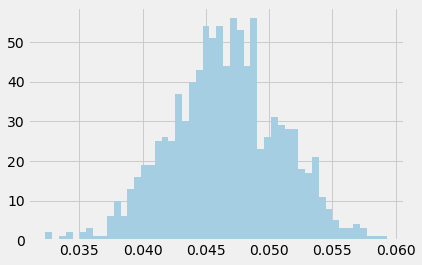

In [ ]:
plt.hist(visit_ates, bins=50)
plt.show()

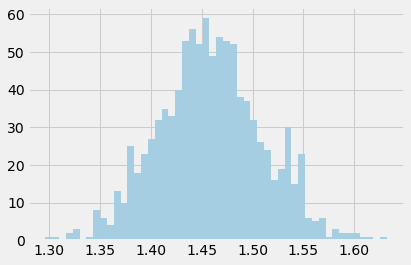

In [ ]:
plt.hist(visit_pates, bins=50)
plt.show()

In [ ]:
with open('hw1_visit_ate_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (stats.loc['visit', 'uplift'], (np.percentile(visit_ates, q=5), np.percentile(visit_ates, q=95))),
        ofile
    )

In [ ]:
with open('hw1_visit_rel_chg_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (
            stats.loc['visit', 'uplift_perc'],
            (np.percentile(visit_pates, q=5), np.percentile(visit_pates, q=95))
        ),
        ofile
    )

##### conversion

In [ ]:
conversion_ates, conversion_pates = ate_bootstrapped(
    data_womens,
    col_value='conversion',
    treated_index=treated_fit_index,
    control_index=control_fit_index,
    n_boot_iterations=1000
)

In [ ]:
print(np.percentile(conversion_ates, q=5), np.percentile(conversion_ates, q=95))

0.0017234618171087064 0.005197769397266037


In [ ]:
print(np.percentile(conversion_pates, q=5), np.percentile(conversion_pates, q=95))

(1.2813125744826603, 2.353759420201732)


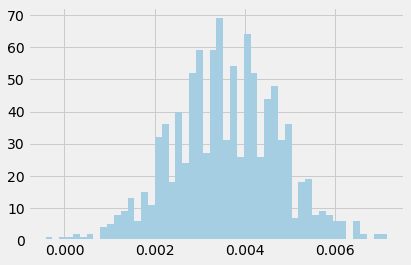

In [ ]:
plt.hist(conversion_ates, bins=50)
plt.show()

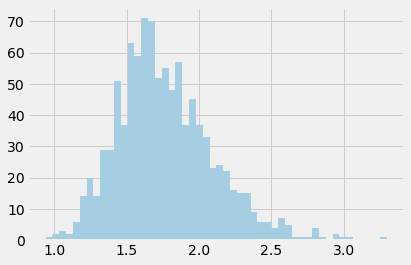

In [ ]:
plt.hist(conversion_pates, bins=50)
plt.show()

In [ ]:
with open('hw1_conversion_ate_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (stats.loc['conversion', 'uplift'], (np.percentile(conversion_ates, q=5), np.percentile(conversion_ates, q=95))),
        ofile
    )

In [ ]:
with open('hw1_conversion_rel_chg_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (
            stats.loc['conversion', 'uplift_perc'],
            (np.percentile(conversion_pates, q=5), np.percentile(conversion_pates, q=95))
        ),
        ofile
    )

##### spend

In [ ]:
spend_ates, spend_pates = ate_bootstrapped(
    data_womens,
    col_value='spend',
    treated_index=treated_fit_index,
    control_index=control_fit_index,
    n_boot_iterations=1000
)

In [ ]:
print(np.percentile(spend_ates, q=5), np.percentile(spend_ates, q=95))

(0.22051922227293505, 0.8718509619864722)


In [ ]:
print(np.percentile(spend_pates, q=5), np.percentile(spend_pates, q=95))

(1.3169732288257918, 2.9058181377381183)


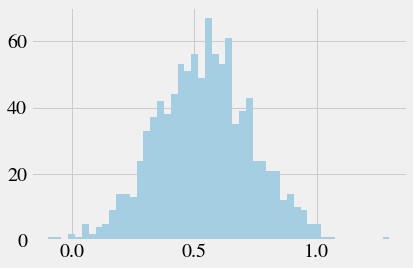

In [ ]:
plt.hist(spend_ates, bins=50)
plt.show()

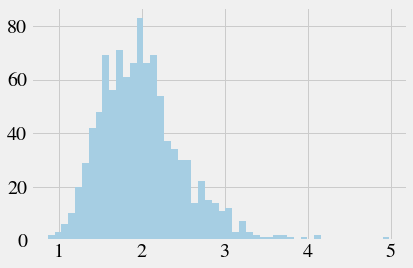

In [ ]:
plt.hist(spend_pates, bins=50)
plt.show()

In [ ]:
with open('hw1_spend_ate_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (stats.loc['spend', 'uplift'], (np.percentile(spend_ates, q=5), np.percentile(spend_ates, q=95))),
        ofile
    )

In [ ]:
with open('hw1_spend_rel_chg_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (
            stats.loc['spend', 'uplift_perc'],
            (np.percentile(spend_pates, q=5), np.percentile(spend_pates, q=95))
        ),
        ofile
    )